# Lorentz Booster (2-D case)
- Generate a whole bunch of particles moving at some relative velocity, then lorentz boost into their frame. This is done compactly by

In [2]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde
import scipy.stats as stats
%matplotlib inline

# my own little library for dealing with four vectors
import fourvectors as fv

In [3]:
### Constants
c = 3E8

### Create enums of particle properties, could be useful for multi-species experiments
class Proton(Enum):
    NAME   = "PROTON"
    MASS   = 1.672E-27 #kg
    CHARGE = 1.602E-19 #C

class Electron(Enum):
    NAME   = "ELECTRON"
    MASS   = 9.109E-21 #kg
    CHARGE =-1.602E-19 #C

class Reference(Enum):
    """A particle that is simply here to be a reference point."""
    NAME   = "REFERENCE PARTICLE"
    MASS   = 0        #kg
    CHARGE = 0        #C

In [4]:
### Create the particle class, this holds all of the nice info about each particle
class Particle():
    def __init__(
            self,
            species,
            pos0_3v = None,  # a three-position
            pos0_4v = None,  # a four-position
            v0_3v  = None,  # a three-velocity
            v0_4v  = None,  # a four-velocity
            frame  = "LAB"  # defaults to lab frame
        ):

        ### HANDLE INITIAL VELOCITIES

        # if no initial three-velocity specified, assume 0
        if v0_3v is None or v0_4v is None:
            v0_4v = np.array([0, 0, 0, 0])

        # if there is a 3v provided, convert it
        if v0_3v is not None:
            # otherwise set the four velocity to match it
            v0_4v = fv.to_four_velocity(v0_3v)

        ### HANDLE INITIAL POSITIONS

        # if no position specified, assume origin
        if pos0_3v is None or pos0_4v is None:
            pos0_4v = np.array([0, 0, 0, 0])

        # if there is a pos 3v provided, convert it
        if pos0_3v is not None:
            pos0_4v = fv.to_four_position(pos0_3v, 0)

        # Get the parameters from the species of particle
        self.name = species.NAME.value
        self.mass = species.MASS.value
        self.charge = species.CHARGE.value

        self.vel_4v = v0_4v    # four velocity
        self.pos_4v = pos0_4v  # four position
        self.frame  = frame

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        # if the frame is lab, then we're boosting to another particle
        if self.frame == "LAB":
            self.frame = other.name
        else:
            self.frame = other.frame

        # first lorentz boost the velocity
        self.lorentz_boost_from_4v(other.vel_4v)

        # then shift it
        if self.name == "REFERENCE PARTICLE":
            # here, the particle is the reference, and becomes the new reference frame
            self.pos_4v = self.get_separation(other)
        else:
            # otherwise lorentz the separation vector given the velocity of the other
            # (likely the reference)
            self.pos_4v = np.linalg.matmul(
                    fv.lorentz_matrix_x_4v(other.vel_4v), self.get_separation(other)
                )

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    def lorentz_boost_from_4v(self, to_vel_4v):
        """Lorentz boost given a four-velocity"""
        lorentz_matrix = fv.lorentz_matrix_x_4v(to_vel_4v)
        self.vel_4v = np.linalg.matmul(lorentz_matrix, self.vel_4v)

    def lorentz_boost_from_3v(self, to_vel_3v):
        """Lorentz boost given a three-velocity"""
        self.lorentz_boost_from_4v(fv.to_four_velocity(to_vel_3v))

    def get_separation(self, other):
        """"get the separation vector between the two positions"""
        return self.pos_4v - other.pos_4v

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel_4v)

    def get_3p(self):
        return fv.to_three_position(self.pos_4v)

In [5]:
np.set_printoptions(formatter={'float': '{:.5e}'.format})

reference = Particle(Reference, v0_3v = np.array([2.9999E8, 0, 0]), pos0_3v=np.array([0,0,0]))
other_particle = Particle(Electron, v0_3v = np.array([2E8, 0, 0]), pos0_3v=np.array([1,50,0]))

print(f"--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

# perform the lorentz boost
other_particle.lorentz_boost_to(reference)
reference.boost_as_reference()

print(f"\n\n--- {reference.frame} FRAME ---")
print(f"{reference.name} Velocity: {reference.get_3v()}")
print(f"{reference.name} Position: {reference.get_3p()[0]}")
print(f"{other_particle.name} Velocity: {other_particle.get_3v()}")
print(f"{other_particle.name} Position: {other_particle.get_3p()[0]}")

--- LAB FRAME ---
REFERENCE PARTICLE Velocity: [[2.99990e+08 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[2.00000e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.00000e+00 5.00000e+01 0.00000e+00]


--- REFERENCE PARTICLE FRAME ---
REFERENCE PARTICLE Velocity: [[0.00000e+00 0.00000e+00 0.00000e+00]]
REFERENCE PARTICLE Position: [0.00000e+00 0.00000e+00 0.00000e+00]
ELECTRON Velocity: [[-2.99950e+08 0.00000e+00 0.00000e+00]]
ELECTRON Position: [1.22476e+02 5.00000e+01 0.00000e+00]


# Bunch of particles exercise (2-D)
I'll assume 10000 particles moving at a normally distributed velocity, still in the $\hat{x}$ directions- but now we're going to vary the positions.

In [28]:
# generate a sample of NUM_PARTICLES particles
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6
MU_POS, SIGMA_POS = 0, 10

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the x direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # could be risky, as the velocity can raise a ValueError
        # if it decides to go above c. its possible, but just
        # really improbable
        v0_3v=[np.random.normal(MU_VEL, SIGMA_VEL), 0, 0],
        pos0_3v=[np.random.normal(MU_POS, SIGMA_POS), np.random.normal(MU_POS, SIGMA_POS) ,0]
        ))

def plotNormalWithLine(s, title=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title)
    plt.plot(bins, 1/(SIGMA_VEL * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - MU_VEL)**2 / (2 * SIGMA_VEL**2) ),
            linewidth=2, color='r')

def getBins1D(s, nbins=50):
    return np.histogram(s, bins=nbins, density=True) # histo, bin_edges

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

Text(0.5, 1.0, 'particle positions')

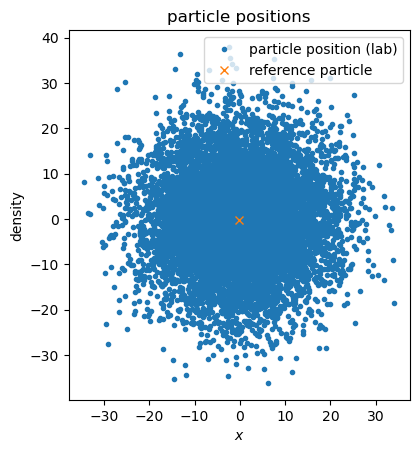

In [29]:
# but the more interesting plot is likely the positions
# i'll just start with printing the x plot
plt.xlabel("$x$")
plt.ylabel("density")
plt.plot(particle_pos[:,0], particle_pos[:,1], '.', label="particle position (lab)")
plt.plot(ref_pos[0], ref_pos[1], 'x', label="reference particle")
plt.legend()
plt.gca().set_aspect("equal")
plt.title("particle positions")

In [30]:
# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()
# get the velocities and positions of each particle
particle_vel_boost = np.array([particle.get_3v() for particle in particle_array])
particle_pos_boost = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel_boost = np.mean(particle_vel, axis=0)[0]
ref_pos_boost = np.mean(particle_pos, axis=0)

Text(0.5, 1.0, 'Particle Positions')

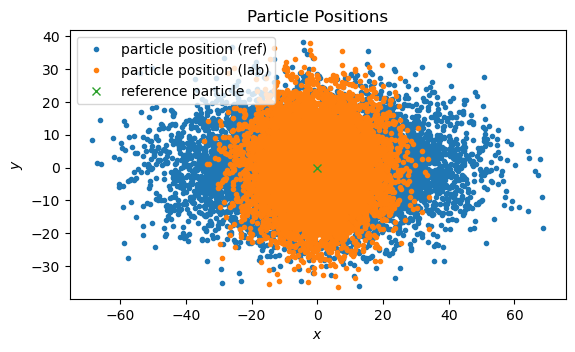

In [31]:
# but the more interesting plot is likely the positions
# i'll just start with printing the x plot
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(particle_pos_boost[:,0], particle_pos_boost[:,1], '.', label="particle position (ref)")
plt.plot(particle_pos[:,0], particle_pos[:,1], '.', label="particle position (lab)")
plt.plot(ref_pos[0], ref_pos[1], 'x', label="reference particle")
plt.legend()
plt.gca().set_aspect("equal")
plt.title("Particle Positions")

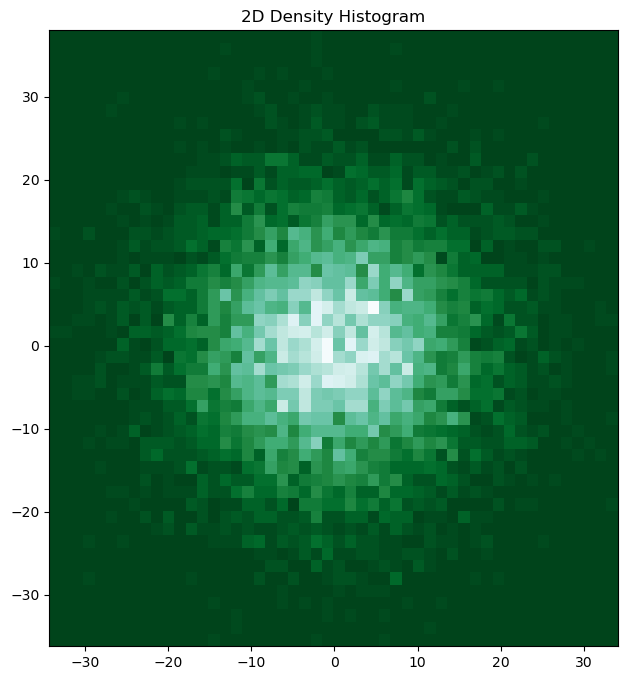

In [77]:
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize=(8, 8))



# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 50
k = gaussian_kde(particle_pos[:,0:2].T)
xi, yi = np.mgrid[particle_pos[:,0].min():particle_pos[:,0].max():nbins*1j, particle_pos[:,1].min():particle_pos[:,1].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# add shading
axes.set_title('2D Density Histogram')
# axes.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes.hist2d(particle_pos[:,0], particle_pos[:,1], bins=nbins, cmap=plt.cm.BuGn_r)
fig.gca().set_aspect("equal")

## Multi-Gaussian Fitting Exercise
The goal is to take a histogram and fit it with a whole bunch of gaussians, with some parameter that affects smoothness. More Gaussians -> More Spikyness, Less Gaussians -> Less Spikyness


In [10]:
# get the histograms for the positions
lab_density, lab_bins = getBins1D(particle_pos[:,0])
ref_density, ref_bins = getBins1D(particle_pos_boost[:,0])

### Gaussian Function
$$
g(x) = \frac{\exp\left(-\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2}\right)}{\sigma \sqrt{2\pi}}
$$
this is the lambda below

[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, RANGE=-34.97725856140477-34.67771825623827


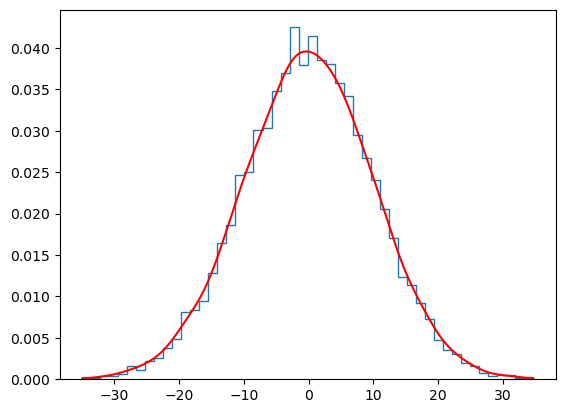

In [11]:
gaussian = lambda x, sig, mu: np.exp(-(x - mu)**2/(2 * sig**2))

class multiGaussFit():
    def __init__(
                    self,
                    arr,
                    nbins:int = 50,
                    ngaussians:int = 1,
                    width:float = 10.0,
                    mesh = None
                ):

        # get the histogram and bins arrays from the input array
        histo, bins = np.histogram(arr, bins=nbins, density=True)

        # bins = (bins[1:] + bins[:-1])/2

        # if no mesh specified, then overwrite it with a guess
        if mesh is None:
            self.mesh = np.linspace(bins[0], bins[-1], 100000)
            print(f"[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, RANGE={bins[0]}-{bins[-1]}")
        # if there IS a mesh, then sanitize it
        else:
            self._mesh_isclean()
            # if the mesh is clean, then we good
            self.mesh = mesh


        # set up the array that contains where the gaussians will be centered
        eval_pts = np.zeros((ngaussians, 2))

        # first seed where the gaussians should probably be
        guesses = np.linspace(bins[1], bins[-2], ngaussians)

        # create a place to hold that gaussian fit
        fitted_line = 0
        normsum = 0
        for i in range(ngaussians):
            # get the index of the values closest
            lower_index = int((guesses[i] - bins[0])/(bins[1] - bins[0]))

            # then place the gaussian's peak location at
            eval_pts[i] = ((bins[lower_index]+bins[lower_index+1])/2, histo[lower_index]) # (loc, amplitude)

            # create the gaussians
            fitted_line += eval_pts[i][1] * gaussian(self.mesh, sig=width, mu=eval_pts[i][0])
            normsum += eval_pts[i][1] * (width * np.sqrt(2 * np.pi))

        fitted_line /= normsum

        # plot the where the peaks of the gaussians should be
        plt.stairs(histo, bins)
        # plt.plot(eval_pts[:,0], eval_pts[:,1], 'kx',  markersize=12)
        plt.plot(self.mesh, fitted_line, 'r-')

        self.fitted_line = fitted_line

    def _mesh_isclean(self):
        """Ensures the mesh provided is uniformly spaced and monotonically increasing."""
        #uniform spacing check
        dx = np.diff(self.mesh)
        if not (np.allclose(dx, dx[0]) and np.all(dx > 0)):
            raise ValueError("Mesh is not clean!!!")

    def __call__(self, val, pltpoint = None):
        # get the closest point on the mesh
        # get the index of the values closest

        # clamp the value to be in the mesh range
        val = np.clip(val, self.mesh[0], self.mesh[-1])

        lower_index = int((val - self.mesh[0])/(self.mesh[1] - self.mesh[0]))

        # if the user wants to plot where they're getting the value
        if pltpoint is not None:
            plt.plot(self.mesh[lower_index], self.fitted_line[lower_index], "kx")

        return self.fitted_line[lower_index]

fit = multiGaussFit(particle_pos[:,0], nbins=50, ngaussians=50, width=2)

Create particle distribution, then bin those to get rho, then use jefimenko to get the E at those points
they can be inside a cylinder or sphere.

1. use gauss law to get a plot of |E| (gauss's law for (long) cylinder)
2. then do sphere inside of a cylinder
3. particle distribution inside of cylinder
4. particle distribution moving inside of cylinder

# Gaussian Quadrature
I am implementing
$$
\int_a^b f(x)\,dx = \int_{-1}^1 f \left(\frac{(b-a)t + (b+a)}{2}\right) \frac{(b-a)}{2} \, dt
$$

In [12]:
from numpy.polynomial.legendre import leggauss

def linTransform(t, a, b):
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b - a) * t + (a + b))

def gaussQuad3DVec(fxn, x_bounds, y_bounds, z_bounds, n):
    roots, weights = leggauss(n)
    ax, bx = x_bounds
    ay, by = y_bounds
    az, bz = z_bounds

    result = np.zeros(3)

    for i in range(n):
        # get the root from -1->1 to ax->bx
        x = linTransform(roots[i], ax, bx)
        wx = weights[i]
        for j in range(n):
            y = linTransform(roots[j], ay, by)
            wy = weights[j]
            for k in range(n):
                z = linTransform(roots[k], az, bz)
                wz = weights[k]

                fx, fy, fz = fxn(x, y, z)
                w = wx * wy * wz
                result += w * np.array([fx, fy, fz])

    scale = 0.125 * (bx - ax) * (by - ay) * (bz - az)
    return scale * result

def gaussQuad3DCylVec(fxn, s_bounds, z_bounds, phi_bounds, n):
    # multiply our function by the volume element (jacobian)
    cyl_fxn = lambda r, z, phi: fxn(r, z, phi) * np.array([r, 0, 0])
    return gaussQuad3DVec(cyl_fxn, s_bounds, z_bounds, phi_bounds, n)


## Jefimenko's Equation Quadrature
I am solving the first term of Jefimenko's Equation,
$$
E_{rad} = \frac{1}{4\pi\epsilon_0} \int \frac{\rho(\textbf{r}', t_r)(\textbf{r}-\textbf{r}')}{|\textbf{r}-\textbf{r}'|^3} d\tau
$$
Assuming a uniform cylinder of charge density $\rho$, with the origin in the center and the field point directly above the cylinder.

In [13]:
def efldCylinder(R: float, rad_cyl: float, len_cyl: float, quad_points: int = 3, rho=None):
    """Compute radial E-field from a finite uniformly charged cylinder using Jefimenko's first term.
    Field is evaluated at a point R away from the cylinder's axis."""

    if rho is None:
        rho = lambda s, z, phi: 1  # Uniform density

    def integrand(s, z, phi):
        # convert the source and field point to be in cartesian
        field_pt = np.array([R, 0, 0])
        source_pt = np.array([s * np.cos(phi), s * np.sin(phi), z])
        separation = field_pt - source_pt
        return rho(s, z, phi) * separation / norm(separation)**3

    return gaussQuad3DCylVec(
        fxn=integrand,
        s_bounds=(0, rad_cyl),
        z_bounds=(-len_cyl / 2, len_cyl / 2),
        phi_bounds=(0, 2 * np.pi),
        n=quad_points
    ) / (4 * np.pi)

### PARAMETERS ###

rad_cyl = 2 # radius of cylinder
len_cyl = 4 # length of cylinder
q_pts = 12  # number of quadrature points
mesh = np.linspace(0.1, 10, 100)

# Case 1: Uniform charged cylinder
efld_vals_const = [efldCylinder(R=r, rad_cyl=rad_cyl, len_cyl=len_cyl, quad_points=q_pts) for r in mesh]
efld_mags_const = [norm(E) for E in efld_vals_const]

# Case 2: Spherical cutoff charge thing
rho_sphere = lambda s, z, phi: 1 / (4/3 * np.pi * rad_cyl**3) if (np.sqrt(s**2 + z**2) < rad_cyl) else 0
efld_vals_sphere = [efldCylinder(R=r, rad_cyl=rad_cyl, len_cyl=len_cyl, rho=rho_sphere, quad_points=q_pts) for r in mesh]
efld_mags_sphere = [norm(E) for E in efld_vals_sphere]

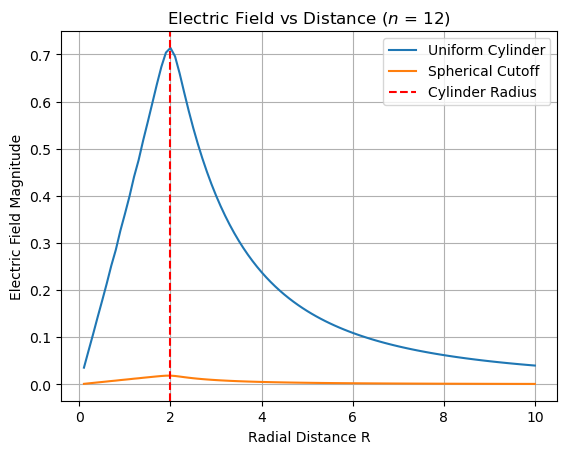

In [14]:
# Plotting
plt.plot(mesh, efld_mags_const, label="Uniform Cylinder")
plt.plot(mesh, efld_mags_sphere, label="Spherical Cutoff")
plt.axvline(x=rad_cyl, label="Cylinder Radius", color="r", linestyle='--')
plt.xlabel("Radial Distance R")
plt.ylabel("Electric Field Magnitude")
plt.legend()
plt.title(f"Electric Field vs Distance ($n$ = {q_pts})")
plt.grid(True)
plt.show()